In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join
import torch
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom
from utils.pixart_utils import state_dict_convert
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Pleas

In [3]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"

config = read_config(join(savedir, 'config.py'))

weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()

transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

2025-07-09 13:42:32,481 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))

/tmp/ipykernel_851769/1495998778.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))


<All keys matched successfully>

In [5]:
text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndemb/caption_feature_wmask'
emb_data = th.load(join(text_feat_dir_old, "word_embedding_dict.pt"))
rndpos_encoder = RandomEmbeddingEncoder_wPosEmb(emb_data["embedding_dict"], 
                                              emb_data["input_ids2dict_ids"], 
                                              emb_data["dict_ids2input_ids"], 
                                              max_seq_len=20, embed_dim=4096,
                                              wpe_scale=1/6).to("cuda")

/tmp/ipykernel_851769/3803893638.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb_data = th.load(join(text_feat_dir_old, "word_embedding_dict.pt"))


In [6]:
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
# encoder = T5EncoderModel.from_pretrained(T5_path)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
pipeline.tokenizer = tokenizer
pipeline.text_encoder = rndpos_encoder
pipeline.to(device="cuda", dtype=weight_dtype);

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/30 [00:00<?, ?it/s]

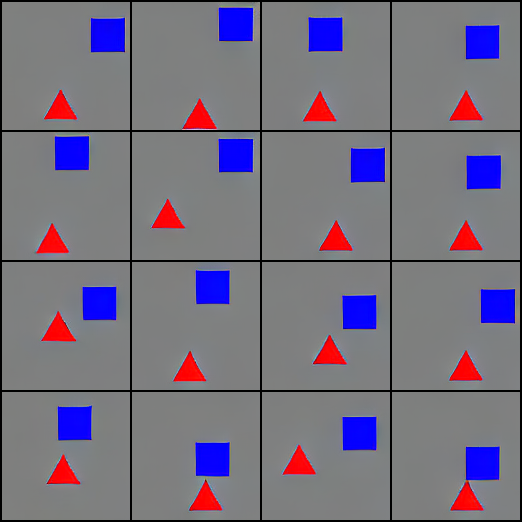

In [13]:
# pipeline.transformer = pipeline.transformer.to(device="cuda", dtype=weight_dtype)
# pipeline.text_encoder = rndpos_encoder.to(device="cuda", dtype=weight_dtype)
prompt = "red triangle below and to the left of blue square"    
output = pipeline(prompt, 
        num_inference_steps=30,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        device="cuda")
display(pil_images_to_grid(output.images))

In [9]:
pipeline.transformer = replace_attn_processor(pipeline.transformer)
attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
attnvis_store.setup_hooks()

Setting up hooks for PixArt attention modules:
- Block 0
- Block 1
- Block 2
- Block 3
- Block 4
- Block 5
- Block 6
- Block 7
- Block 8
- Block 9
- Block 10
- Block 11


torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/14 [00:00<?, ?it/s]

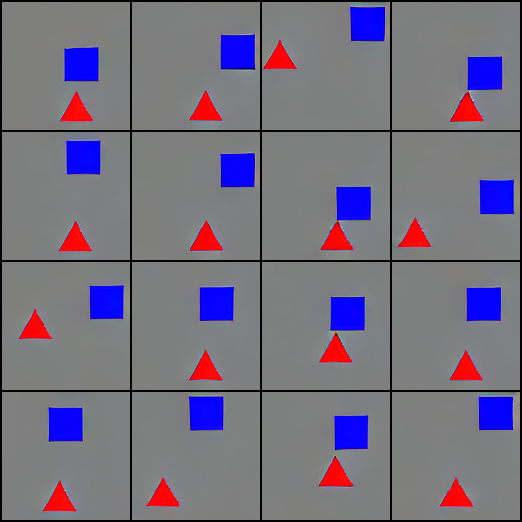

In [14]:
attnvis_store.clear_activation()
prompt = "red triangle below and to the left of blue square"
output = pipeline(prompt, 
        num_inference_steps=14,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

In [11]:
attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'], dim=0) for layer_i in range(12)]
attn_map_stacked = th.stack(attn_map_stacked, dim=0)
cross_attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'], dim=0) for layer_i in range(12)]
cross_attn_map_stacked = th.stack(cross_attn_map_stacked, dim=0)
print("attn_map_stacked.shape: ", attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_tokens)
print("cross_attn_map_stacked.shape: ", cross_attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_word_tokens)

attn_map_stacked.shape:  torch.Size([12, 14, 32, 12, 64, 64])
cross_attn_map_stacked.shape:  torch.Size([12, 14, 32, 12, 64, 20])


## Search for attention maps that match a certain template

In [31]:
import numpy as np
from tqdm.auto import trange
import seaborn as sns
import matplotlib.pyplot as plt
import torch as th
from utils.attention_analysis_lib import plot_attention_layer_head_heatmaps
from utils.attention_analysis_lib import *
from utils.cv2_eval_utils import find_classify_object_masks
from circuit_toolkit.plot_utils import saveallforms

figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/attn_vis_figs"
os.makedirs(figdir, exist_ok=True)

### Find tokens with certain structure

In [32]:
token_splits = pipeline.tokenizer.tokenize(prompt)

In [33]:
pipeline.tokenizer.encode(prompt)

[1131, 19938, 666, 11, 12, 8, 646, 13, 1692, 2812, 1]

In [34]:
# Create multi-hot masks for each category
def create_multi_hot_token_mask(tokens, target_words, seq_len=None):
    mask = th.zeros(len(tokens) if seq_len is None else seq_len, dtype=th.bool)
    for i, token in enumerate(tokens):
        # Remove the special prefix if present
        clean_token = token.replace('▁', '') if token.startswith('▁') else token
        if clean_token in target_words:
            mask[i] = True
    return mask

# Create multi-hot masks for different types of words
token_splits = pipeline.tokenizer.tokenize(prompt)
print("Token splits:", token_splits)

# Define word categories
color_words = ['red', 'blue']
shape_words = ['triangle', 'square']
spatial_words = ['below', 'left', 'above', 'right']
preposition_words = ['and', 'to', 'the', 'of']

color_mask = create_multi_hot_token_mask(token_splits, color_words)
shape_mask = create_multi_hot_token_mask(token_splits, shape_words)
spatial_mask = create_multi_hot_token_mask(token_splits, spatial_words)
preposition_mask = create_multi_hot_token_mask(token_splits, preposition_words)

print("Color mask (red, blue):", color_mask)
print("Shape mask (triangle, square):", shape_mask)
print("Spatial mask (below, left):", spatial_mask)
print("Preposition mask (and, to, the, of):", preposition_mask)

# Show which tokens are selected by each mask
print("\nColor tokens:", [token for i, token in enumerate(token_splits) if color_mask[i]])
print("Shape tokens:", [token for i, token in enumerate(token_splits) if shape_mask[i]])
print("Spatial tokens:", [token for i, token in enumerate(token_splits) if spatial_mask[i]])
print("Preposition tokens:", [token for i, token in enumerate(token_splits) if preposition_mask[i]])

Token splits: ['▁red', '▁triangle', '▁below', '▁and', '▁to', '▁the', '▁left', '▁of', '▁blue', '▁square']
Color mask (red, blue): tensor([ True, False, False, False, False, False, False, False,  True, False])
Shape mask (triangle, square): tensor([False,  True, False, False, False, False, False, False, False,  True])
Spatial mask (below, left): tensor([False, False,  True, False, False, False,  True, False, False, False])
Preposition mask (and, to, the, of): tensor([False, False, False,  True,  True,  True, False,  True, False, False])

Color tokens: ['▁red', '▁blue']
Shape tokens: ['▁triangle', '▁square']
Spatial tokens: ['▁below', '▁left']
Preposition tokens: ['▁and', '▁to', '▁the', '▁of']


In [ ]:
import cv2
positive_threshold = 180 
MAXIMUM = 255

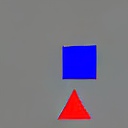

In [56]:
output[0].images[0]

In [54]:
df, object_masks = find_classify_object_masks(output[0].images[0])

In [55]:
df

,Object,Shape,Color (RGB),"Center (x, y)",Area,Expected Area
0,1,Triangle,"(246, 13, 15)","(75, 103.0)",463.5,443.405007
1,6,Square,"(8, 5, 249)","(79, 62)",1088.5,1024.000000


In [49]:
df, object_masks = find_classify_object_masks(output[0].images[0])
obj_masks_resized = [cv2.resize(obj_mask, (8, 8), interpolation=cv2.INTER_CUBIC) for obj_mask in object_masks]
obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
obj_masks_resized_float = [obj_mask.astype(float) / MAXIMUM for obj_mask in obj_masks_resized]
# object_masks is a list of binary masks (numpy arrays) for each detected object

In [50]:
obj_masks_resized_float

[array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.20392157,
         0.        , 0.        , 0.        ]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,

In [ ]:
# build masks for spatial tokens

In [ ]:
plot_attention_layer_head_heatmaps

<function utils.attention_analysis_lib.plot_attention_layer_head_heatmaps(score_tensor, title_str, figsize=(12, 8), sample_idx=-1, num_heads=6, share_clim=False, panel_shape=None)>

In [51]:
df

,Object,Shape,Color (RGB),"Center (x, y)",Area,Expected Area
0,1,Triangle,"(246, 13, 15)","(75, 103.0)",463.5,443.405007
1,6,Square,"(8, 5, 249)","(79, 62)",1088.5,1024.000000
